In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# PascalVOC2012

This notebook demonstrates how to compile the PascalVOC2012 dataset as a LITDataset.

Note that the paths and imports are placed in a local `localpaths.py` file, and is not part of the git repo.

In [2]:
import numpy as np
import pickle
import os
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tarfile
import xml
import sys

from PIL import Image
from IPython import display

In [3]:
sys.path.append('..')
from litdata.writer import LITWriter
from litdata.litdata import LITDataset

In [4]:
from localpaths import (
    PVOC_ROOT, PVOC_VAL, LITDATAPATH, PVOC_LABELDICT
)

In [5]:
root = PVOC_ROOT
instance = 'SegmentationObject/'
semantic = 'SegmentationClass/'
images = 'JPEGImages/'
annotations = 'Annotations/'

class_to_id = {'background': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 
               'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 
               'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13,
               'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 
               'sofa': 18, 'train': 19, 'tvmonitor': 20, 'void': 255}

labeldict = {v:k for k,v in class_to_id.items()}

In [6]:
def get_objdict(filename):
    img = Image.open(os.path.join(root, images, filename + '.jpg'))
    objdict = {'__key__': filename, 'jpg': img}
    segpath = os.path.join(root, semantic, filename + '.png')
    inspath = os.path.join(root, instance, filename + '.png')
    annpath = os.path.join(root, annotations, filename + '.xml')
        
    if os.path.isfile(segpath):
        seg = np.array(Image.open(segpath))
        objdict['semantic.seg8'] = seg

    if os.path.isfile(inspath):
        ins = np.array(Image.open(inspath))
        objdict['instance.seg8'] = ins
    
    if os.path.isfile(annpath):
        tree = xml.etree.ElementTree.parse(annpath)
        bbox = []
        for object_element in tree.getroot().iter('object'):
            object_dict = {}
            for element in object_element:
                if element.tag == 'bndbox':
                    for b in element:
                        object_dict[b.tag] = float(b.text)
                elif element.tag == 'name':
                    object_dict['class'] = class_to_id[element.text]
            bbox.append(object_dict)

        objdict['bbox.json'] = bbox
    
    return objdict
    

In [7]:
imgfiles = [os.path.splitext(t)[0] for t in os.listdir(os.path.join(root, images))]
    
with open(PVOC_VAL, 'r') as infile:
    valfiles = [line for line in infile.read().split()]
    
trainfiles = [t for t in imgfiles if (t not in valfiles)]

In [8]:
len(trainfiles), len(valfiles), len(imgfiles)

(27437, 5823, 33260)

In [9]:
additional_metadata = {
    'num_segmentation_classes': 22,
    'num_segmentation_classes_wo_void': 21,
    'website': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/',
}

In [10]:
with LITWriter(
    'PascalVOC2012', 
    LITDATAPATH, 
    additional_metadata=additional_metadata,
    groupname = 'DSB@UiO',
    shard_maxfiles = 5000,
) as litwriter:
    for i, fname in enumerate(trainfiles):
        objdict = get_objdict(fname)
        litwriter.train.write(objdict)
        if i % 250 == 0:
            display.clear_output(wait=True)
            print(f'train: {i:12d}/{len(trainfiles):12d}')
            print(litwriter.train)
            

    for i, fname in enumerate(valfiles):
        objdict = get_objdict(fname)
        litwriter.val.write(objdict)
        if i % 250 == 0:
            display.clear_output(wait=True)
            print(f'val:   {i:12d}/{len(valfiles):12d}')
            print(litwriter.val)


val:           5750/        5823
ShardWriter(
	Current Shard: /work2/litdata/PascalVOC2012/val_0001.tar
	Current Shard Size: 0.03 GB
	Current Shard File Count: 751
	Total File Count: 5751
)


In [11]:
dataset = LITDataset('PascalVOC2012', LITDATAPATH, override_extensions=['jpg', 'semantic.seg8'], train=True)

In [12]:
dataset

LITDataset(
    	fold=train,
	length=1791,
	use_extensions=('.jpg', '.semantic.seg8'),
	num_segmentation_classes = 22,
	num_segmentation_classes_wo_void = 21,
	website = http://host.robots.ox.ac.uk/pascal/VOC/voc2012/,
	num_train = 27437,
	num_val = 5823,
)

In [13]:
dataset.cfg

{'train': '/train_{0000..0005}.tar',
 'val': '/val_{0000..0001}.tar',
 'extensions': ['jpg', 'semantic.seg8', 'instance.seg8', 'bbox.json'],
 'metadata': {'num_segmentation_classes': 22,
  'num_segmentation_classes_wo_void': 21,
  'website': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/',
  'num_train': 27437,
  'num_val': 5823}}

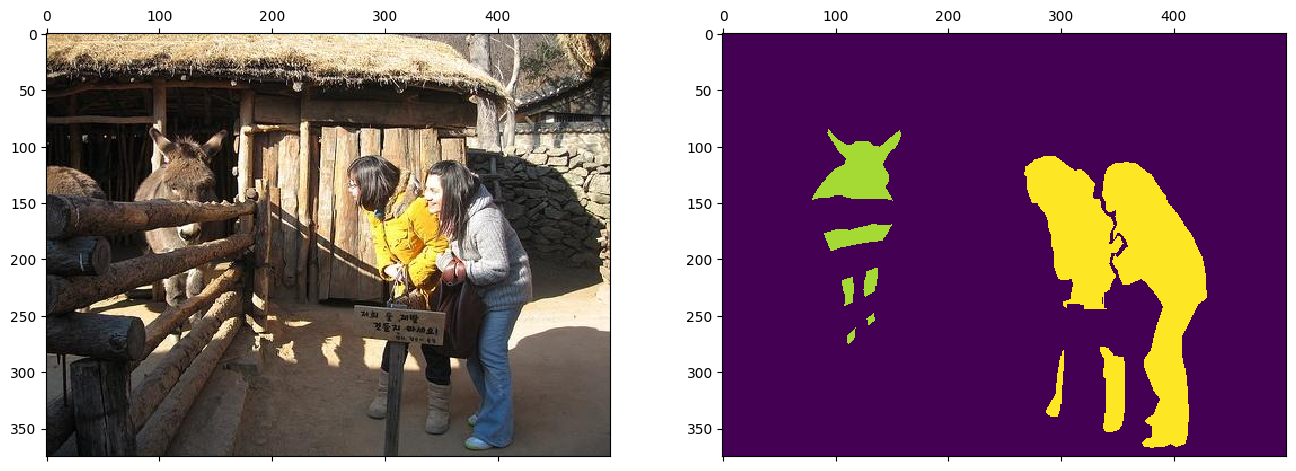

In [14]:
j = 395
novoidmap = np.arange(256)
novoidmap[-1] = 0
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].matshow(np.array(dataset[j][0]))
ax[1].matshow(novoidmap[np.array(dataset[j][1])])

In [15]:
with open(PVOC_LABELDICT, 'w') as outfile:
    json.dump(labeldict, outfile)